In [34]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score

data = pd.read_csv('cv.csv')
print(data.columns)
df = data
df.head(5)

Index(['Category', 'Resume'], dtype='object')


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [35]:
classes = df['Category'].value_counts()
keys = classes.keys().to_list()

# print number of unique categories
print('Number of unique categories: ', len(keys))


df = df[df['Category'].isin(keys)]
df['Category'].value_counts()

Number of unique categories:  25


Testing                      1120
Java Developer                924
DevOps Engineer               660
Python Developer              559
Blockchain                    540
Hadoop                        504
ETL Developer                 480
Web Designing                 450
HR                            440
Operations Manager            440
Data Science                  400
Sales                         400
Mechanical Engineer           400
Database                      396
PMO                           360
Arts                          360
DotNet Developer              336
Electrical Engineering        330
Business Analyst              308
Health and fitness            303
Network Security Engineer     300
Automation Testing            286
SAP Developer                 264
Civil Engineer                264
Advocate                      200
Name: Category, dtype: int64

In [36]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        # lemmatize text - convert to base form 
        self.wnl = WordNetLemmatizer()
        # creating stopwords list, to ignore lemmatizing stopwords 
        self.stopwords = stopwords.words('english')
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.stopwords]

# removing new line characters, and certain hypen patterns                  
# convert all df['Resume'] to string
df['Resume'] = df['Resume'].astype(str)
df['Resume']=df['Resume'].apply(lambda x: x.replace('\n', ' ').replace('\r', '').replace('- ', ''). replace(' - ', ' to '))

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
# train features and labels 
y = df['Category']
X = df['Resume']
# tdif feature rep 
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')
vectorizer.fit(X)
# transoforming text to tdif features
tfidf_matrix = vectorizer.transform(X)
# sparse matrix to dense matrix for training
X_tdif = tfidf_matrix.toarray()
# encoding text labels in categories 
enc = LabelEncoder() 
enc.fit(y.values)
y_enc=enc.transform(y.values)

X_train_words, X_test_words, y_train, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=10)

X_train = vectorizer.transform(X_train_words)
X_train = X_train.toarray()

X_test = vectorizer.transform(X_test_words)
X_test = X_test.toarray()

c:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


In [38]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
gnb = GaussianNB()
train_preds = gnb.fit(X_train, y_train).predict(X_train)
test_preds = gnb.predict(X_test)

print('Train acc: {0}'.format(accuracy_score(y_train, train_preds)))
print('Test acc: {0}'.format(accuracy_score(y_test, test_preds)))

Train acc: 1.0
Test acc: 1.0


In [39]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=15,verbose=1, C=0.75)

train_preds = logistic.fit(X_train, y_train).predict(X_train)
test_preds = logistic.predict(X_test)

print('Train acc: {0}'.format(accuracy_score(y_train, train_preds)))
print('Test acc: {0}'.format(accuracy_score(y_test, test_preds)))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


Train acc: 1.0
Test acc: 1.0


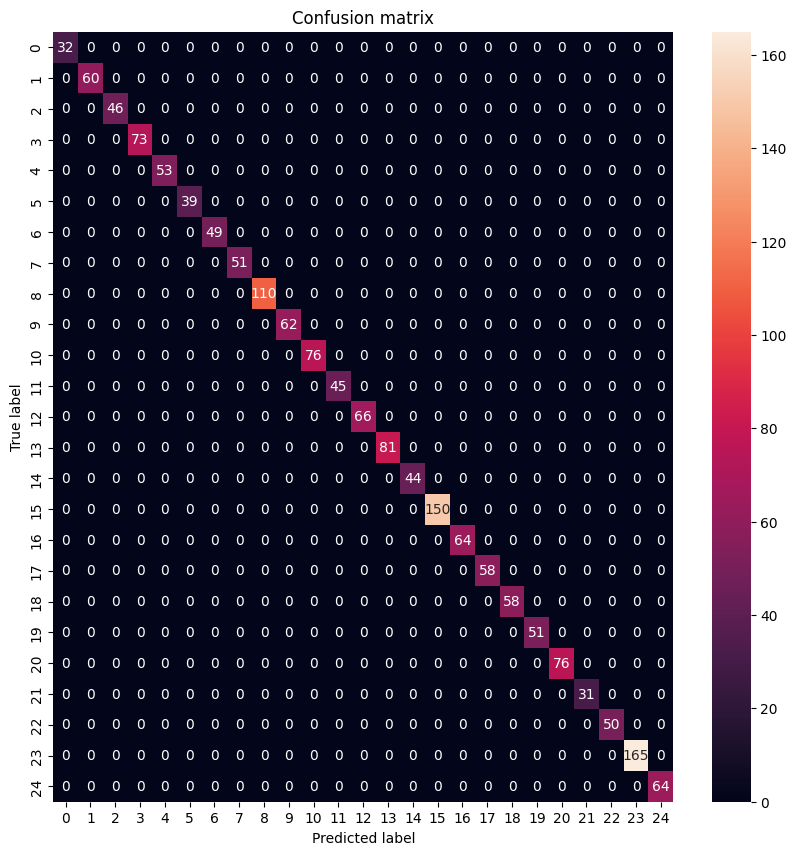

In [40]:
preds_data = {'Resume': [], 'Current Position': [], 'Alternative 1': [], 'Alternative 2': []}
y_preds_proba = logistic.predict_proba(X_test)

counter = 0 
for idx, (pred_row, true_job_position) in enumerate(zip(y_preds_proba, y_test)):
    class_preds = np.argsort(pred_row)
    # delete true class
    for i in [-1, -2]:
        if class_preds[i] == true_job_position:
            class_preds=np.delete(class_preds,i)
    # getting other 2 highest job predictions         
    top_classes = class_preds[-2:]
    # obtaining class name string from int label 
    class_names = enc.inverse_transform(top_classes)
    true_job_position_name = enc.inverse_transform([true_job_position])
    # saving to dict
    preds_data['Resume'].append(X_test_words.iloc[idx])
    preds_data['Current Position'].append(true_job_position_name[0])
    preds_data['Alternative 1'].append(class_names[1])
    preds_data['Alternative 2'].append(class_names[0])    
    counter +=1
      
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#save model
import pickle
pickle.dump(logistic, open('itreq.pkl','wb'))

In [46]:
# load the model from disk and write a function to predict 3 possible jobs
loaded_model = pickle.load(open('itreq.pkl', 'rb'))

def predict_job(text):
    # convert text to tdif features
    text = vectorizer.transform([text])
    text = text.toarray()
    # predict probabilities
    y_preds_proba = loaded_model.predict_proba(text)
    # get top 3 predictions
    class_preds = np.argsort(y_preds_proba[0])
    top_classes = class_preds[-3:]
    # obtain class name string from int label 
    class_names = enc.inverse_transform(top_classes)
    return class_names

# test the function
predict_job('''
Helped develop, debugging and polishing Rahn Monitor to get it ready for the market.

Wrote RahnAPI - a Python script to pull WooCommerce RestAPI responses clean the responses and publish them into the SQL Database at every millisecond.

This helped counter the competitor https://zapier.com/apps/sql-server/integrations/woocommerce. Where they charge R350 per month whereas my script is free you just need to run it on the cloud (in Rahn's cases a Raspberry Pi 4)

To make the script run on the Pi 24/7 I had to create an image and run it in Kubernetes and Docker.
using a FreeTDS driver to connect to SQL.
https://github.com/ADGVLOGS/raspberrypi-pyodbc-docker-image

you can find the repo here for more information.

Website Upgrading for https://rahn.co.za/
I added a WooCommerce plugin on the website to add an Account and Cart page and helped register them on PayFast to accept payments for the software.

I wrote another application as research for them such as a CV parser. The CV parser uses NLP, Machine Learning to extract the fields in any given CV format - (.png, pdf, .docx, etc) and publishes them into the SQL Database. It's not quite accurate yet has around a 60% accuracy. Fields do get messed up and mixed up.
Powered by C# and Python.

Training a Rahn Employee to gain various skills such as Practical Networking (Port-forwarding, IPv4 Public and Private, Linux, SSH, Visual Studio Code - Jypyter Notebooks, httpd (Apache), SQL Server Security)

Built Rahn Monitor with Raymond (Rahn) helping me with Front End from scratch powered by the ADGSDK.

''')

array(['Web Designing', 'Database', 'Data Science'], dtype=object)